In [2]:
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2


In [159]:
# smote and upsampling + validation set pulled from training set (now we have data leakage)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filepath_data = '/Users/krahman/work/tutorials/tensorflow_classification/data/'

df_raw = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1) #del once finished testing

train_sample = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1)
train_label = pd.read_csv(filepath_data + 'mod_y_train.csv').drop('Unnamed: 0', axis=1)
train_sample = pd.concat([train_sample, train_label], axis=1)
test_sample = pd.read_csv(filepath_data + 'mod_x_test.csv').drop('Unnamed: 0', axis=1)
test_label = pd.read_csv(filepath_data + 'mod_y_test.csv').drop('index', axis=1)
test_sample = pd.concat([test_sample, test_label], axis=1)

target = '0'

list_data = [train_sample, test_sample]

class PreProcessing():
    def __init__(self, list_data, target):
        self.target = target
        self.train_sample = list_data[0].copy()
        self.test_sample = list_data[1].copy()
        self.test_sample = self.shuffle_data(self.test_sample)
        self.test_sample, self.val_sample = self._split_test_data()
        self.train_label = self._create_target(self.train_sample)
        self.test_label = self._create_target(self.test_sample)
        self.val_label = self._create_target(self.val_sample)
        self.process_data()
        
    def process_data(self):
        self._print_summary()
        self._training_sets_array()
        self._scale_data()
        
    def shuffle_data(self, dataset):
        return shuffle(dataset).reset_index(drop=True)
    
    def _split_test_data(self):
        return train_test_split(self.test_sample, test_size=.2)
        
    def _create_target(self, dataset):
        return np.array(dataset.pop(self.target))
        
    def _print_summary(self):
        print("Training data shape:", self.train_sample.shape)
        print("Testing data shape:", self.test_sample.shape)
        print("Validation data shape:", self.val_sample.shape)
        print("train_label length:", self.train_label.shape[0])
        print("test_label length:", self.test_label.shape[0])
        print("val_label length:", self.val_label.shape[0])
        
    def _training_sets_array(self):
        self.train_sample = np.array(self.train_sample)
        self.test_sample = np.array(self.test_sample)
        self.val_sample = np.array(self.val_sample)
        
    def _scale_data(self):
        scaler = StandardScaler()
        self.train_sample = scaler.fit_transform(self.train_sample)
        self.test_sample = scaler.transform(self.test_sample)
        self.val_sample = scaler.transform(self.val_sample)

pp = PreProcessing(list_data, target)
# right now, train_sample is copied, so the original train_sample is not modified. We might need to reverse
# our change later when it comes to feeding the model our data.

Training data shape: (190000, 233)
Testing data shape: (47243, 233)
Validation data shape: (11811, 233)
train_label length: 190000
test_label length: 47243
val_label length: 11811


In [ ]:
# create method that ingests selected model, runs through 90 epochs, saves each model, graphs auc results for all
# 90 models. then scores each based on 
# best .1-.9 threshold, then selects the best threshold for each epoch, then tests the best incremental threshold
# for all 90 models. Then selects the top model, top threshold, then saves the model as a tf file. Then load model
# and score it with results. 
# 
# then run through each threshold and picks the
# top 5 scoring models and then runs through each threshold, 

# create method to test each threshold .1-.9 and save all results to a dataframe
# create method that reads dataframe and selects which has the highest auc roc score and returns the best 
# threshold
# create a method to load the algorithm

# create method using code block below that selects each threshold and creates the fine tuning set, which then
# tests each and selects the perfect threshold to use
# create method that saves the new model in tf SavedModel format
# create method that creates results dataframe along with score

In [117]:
# append each val to list and then call order command to order the list 
# Method for fine tuning threshold
list_tune_thres = []

best_thres = .1
temp_val_neg = .1
temp_val_pos = .1
for val in range(0,5):
    temp_val_neg = temp_val_neg - .01
    temp_val_pos = temp_val_pos + .01
    list_tune_thres.append(round(temp_val_neg, 2))
    list_tune_thres.append(round(temp_val_pos, 2))
list_tune_thres.append(round(best_thres, 2))    
    
list_tune_thres.sort()
list_tune_thres

[0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

In [ ]:
# use this in method to run scoring on 

from sklearn.preprocessing import binarize
y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)

list_threshold = [.05, .1, .15, .2, .25, .3, 
                  .35, .4, .45, .5, .55, .6]

list_threshold = [.31, .32, .33, .34, .35, .36, 
                  .37, .38, .39, .4, .41, .42,.43,.44,.45,.46]
for threshold in list_threshold:
    y_pred_class = binarize(y_pred, threshold)#[:,1]
    fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred_class, pos_label=1)
    auc_score = auc(fpr, tpr)
    # list_auc_score.append(auc_score)
    print('auc_score:', auc_score, threshold)  

In [346]:
#CURRENT
import tensorflow as tf
import numpy as np 
from tensorflow import keras

class Model():
    def __init__(self):
        self.filepath_chkpt = './cp.ckpt/'
        self.train_sample = pp.train_sample
        self.train_label = pp.train_label
        self.test_sample = pp.test_sample
        self.test_label = pp.test_label
        self.val_sample = pp.val_sample
        self.val_label = pp.val_label
    
    def _checkpoint_path(self):
        checkpoint_path = "./cp.ckpt/cp-{epoch:04d}.ckpt"
        return checkpoint_path
    
    def _define_checkpoint(self):
        checkpoint_path = self._checkpoint_path()
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_auc', 
                                                         verbose=1,
                                                         save_best_only=False, 
                                                         save_weights_only=True,
                                                         mode='max',
                                                         save_freq='epoch')
        return cp_callback
    
    def create_model(self, model, metrics, lr, loss):
        '''ingests and compiles model'''
        model.compile(optimizer=keras.optimizers.Adam(lr=lr), 
                      loss=loss, metrics=metrics)
        return model
    
    def fit_model(self, model, epochs):
        model = self._save_weights(model)
        model.fit(self.train_sample, self.train_label, 
                  validation_data=(self.val_sample, self.val_label), 
                  batch_size=20, epochs=epochs, shuffle=True, verbose=2, 
                  workers=16, use_multiprocessing=True,
                  callbacks=[cp_callback])
    
    def _save_weights(self, model):
        checkpoint_path = self._checkpoint_path()
        model.save_weights(checkpoint_path.format(epoch=0))
        return model
    
    def save_best_model(self, model, metrics, lr, loss):       
        model = self.create_model(model, metrics, lr, loss)
        filepath = self.filepath_chkpt + 'cp-' + tnnt.best_chkpt + '.ckpt'
        model.load_weights(filepath)
        
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        
        y_pred_class = binarize(y_pred, tnnt.best_threshold)
        
        fpr, tpr, thresholds = roc_curve(pp.test_label, 
                                         y_pred_class, 
                                         pos_label=1)
        auc_score = auc(fpr, tpr)
        
        print(model)
        print('best checkpoint/epoch:', tnnt.best_chkpt)
        print('best threshold:' tnnt.best_threshold)
        print("best auc score:", auc_score)
        
        # NEXT, we need to .savemodel tf format, Then we can create a method that loads the 
        # best model with the binarize method. 
        
        return model #delete return statement?

    
###########################
##### hard code below #####

DF_TRAIN = pp.train_sample

##### Defining Model Parameters #####
neg, pos = np.bincount(train_sample[target])
initial_bias = np.log([pos/neg])
OUTPUT_BIAS = tf.keras.initializers.Constant(initial_bias)
LOSS = keras.losses.BinaryCrossentropy()
LR = .0001
METRICS = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

MODEL_SEQ = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])

# MODEL_SEQ = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])

mod = Model()
model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
# mod.fit_model(model, epochs=100) #comment out until next fitting

In [350]:
# call this after tuning thres methods complete
mod.save_best_model(MODEL_SEQ, METRICS, LR, LOSS)

best auc score: 0.8638064647117835


In [348]:
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

class TuneNeuralNetThreshold():
    def __init__(self):
        self.current_thres = []
        self.top_score = []
        self.df_all_results = pd.DataFrame()
        self.best_chkpt = []
        self.best_threshold = []
        
    def tune_threshold(self, model):
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        
        list_threshold = [.05, .1, .15, .2, .25, .3, .35, .4, .45, 
                          .5, .55, .6, .65, .7, .75, .8, .85, .9]
        self._tune_thres_methods(list_threshold, y_pred)
        list_tune_thres = self._fine_tune_thres()
        self._tune_thres_methods(list_tune_thres, y_pred)
        list_tune_thres = self._fine_tune_thres_2()
        self._tune_thres_methods(list_tune_thres, y_pred)

        # NEXT, take dataframe and pick the highest scoring auc with threshold, then save the model
        # as .tf model
        
        self._create_results_df()
        
        self._save_best_thres()
        
        # NEXT, we need to pass this to our Model class and create and save the final model. 
    
        
    def _tune_thres_methods(self, list_threshold, y_pred):
        list_auc_score = self._calc_thres_score(list_threshold, y_pred)        
        df_results = self._create_df_results(list_auc_score, list_threshold)
        self._calc_best_score(df_results)
        
    def _calc_thres_score(self, list_threshold, y_pred):
        list_auc_score = []
        for thres in list_threshold:
            y_pred_class = binarize(y_pred, thres)
            fpr, tpr, thresholds = roc_curve(pp.test_label, 
                                             y_pred_class, 
                                             pos_label=1)
            auc_score = auc(fpr, tpr)
            list_auc_score.append(auc_score)
        return list_auc_score
    
    def _create_df_results(self, list_auc_score, list_threshold):
        col_thres = pd.Series(list_threshold, name='current_thres')
        col_auc = pd.Series(list_auc_score, name='auc_score')
        df_results = pd.concat([col_thres, col_auc], axis=1)
        return df_results
    
    def _calc_best_score(self, df_results):
        val_max_auc = df_results.auc_score.max()
        df_max_auc = df_results[df_results.auc_score == val_max_auc]
        df_max_auc_index = df_max_auc.index[0]
        self.current_thres = df_results.loc[df_max_auc_index, 'current_thres']
        self.top_score = val_max_auc 
    
    def _fine_tune_thres(self):
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .01
            temp_val_pos = temp_val_pos + .01
            list_tune_thres.append(round(temp_val_neg, 2))
            list_tune_thres.append(round(temp_val_pos, 2))
        list_tune_thres.append(round(self.current_thres, 2))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _fine_tune_thres_2(self):
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .001
            temp_val_pos = temp_val_pos + .001
            list_tune_thres.append(round(temp_val_neg, 3))
            list_tune_thres.append(round(temp_val_pos, 3))
        list_tune_thres.append(round(self.current_thres, 3))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _save_best_thres(self):
        dataset = self.df_all_results.copy()
        val_best_auc = dataset.auc_score.max()
        val_best_chkpt = dataset[dataset.auc_score==val_best_auc].chkpt_epoch
        val_best_thres = dataset[dataset.auc_score==val_best_auc].threshold
        self.best_chkpt = val_best_chkpt[0]
        self.best_threshold = val_best_thres[0]
        
    def _create_results_df(self):
        col_chkpt = pd.Series(tm.chkpt_num, name='chkpt_epoch')
        col_thres = pd.Series(self.current_thres, name='best_threshold')
        col_auc = pd.Series(self.top_score, name='auc_score')
        df_temp = pd.concat([col_chkpt, col_thres, col_auc], axis=1)
        # printing current results
        print(df_temp)
        self.df_all_results = pd.concat([self.df_all_results, df_temp], axis=0)

    
tnnt = TuneNeuralNetThreshold()
# tnnt.tune_threshold(model)

  chkpt_epoch  threshold  auc_score
0        0060      0.159   0.858901
  chkpt_epoch  threshold  auc_score
0        0061      0.123   0.860196
  chkpt_epoch  threshold  auc_score
0        0062       0.21   0.857108
  chkpt_epoch  threshold  auc_score
0        0063      0.275   0.856893
  chkpt_epoch  threshold  auc_score
0        0064      0.162   0.856195
  chkpt_epoch  threshold  auc_score
0        0065      0.141   0.861115
  chkpt_epoch  threshold  auc_score
0        0066      0.251   0.863649
  chkpt_epoch  threshold  auc_score
0        0067      0.168   0.863806
  chkpt_epoch  threshold  auc_score
0        0068       0.12   0.860612


  chkpt_epoch  threshold  auc_score
0        0069      0.181   0.856457
  chkpt_epoch  threshold  auc_score
0        0070      0.079   0.853761
  chkpt_epoch  threshold  auc_score
0        0071      0.209   0.859647
  chkpt_epoch  threshold  auc_score
0        0072      0.102   0.855296
  chkpt_epoch  threshold  auc_score
0        0073      0.223   0.849617
  chkpt_epoch  threshold  auc_score
0        0074      0.141   0.856682
  chkpt_epoch  threshold  auc_score
0        0075      0.225   0.860912
  chkpt_epoch  threshold  auc_score
0        0076      0.077   0.858606
  chkpt_epoch  threshold  auc_score
0        0077      0.115   0.856864


  chkpt_epoch  threshold  auc_score
0        0078      0.186   0.854576
  chkpt_epoch  threshold  auc_score
0        0079      0.161   0.862615
  chkpt_epoch  threshold  auc_score
0        0060      0.159   0.858901
0        0061      0.123   0.860196
0        0062      0.210   0.857108
0        0063      0.275   0.856893
0        0064      0.162   0.856195
0        0065      0.141   0.861115
0        0066      0.251   0.863649
0        0067      0.168   0.863806
0        0068      0.120   0.860612
0        0069      0.181   0.856457
0        0070      0.079   0.853761
0        0071      0.209   0.859647
0        0072      0.102   0.855296
0        0073      0.223   0.849617
0        0074      0.141   0.856682
0        0075      0.225   0.860912
0        0076      0.077   0.858606
0        0077      0.115   0.856864
0        0078      0.186   0.854576
0        0079      0.161   0.862615


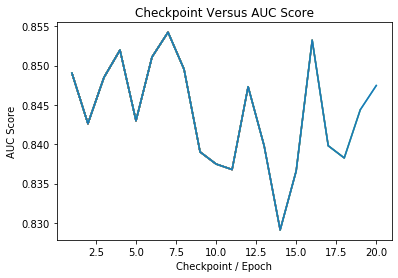

In [349]:
class TuneNeuralNet():
    def __init__(self):
        self.checkpoint_path = './cp.ckpt/'
        self.list_auc_score = []
        self.list_epoch = []
        self.chkpt_num = []
    
    def create_chkpt_list(self):
        
        list_checkpoints = []
        for file in os.listdir(self.checkpoint_path):
            val_checkpoint = file[0:12]
            if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
                list_checkpoints.append(val_checkpoint)
        list_checkpoints.sort()
        return list_checkpoints
    
    def score_chkpts(self):
        list_checkpoints = self.create_chkpt_list()
        list_epoch = []

        for chkpt in list_checkpoints[60:80]: # setting 66:67 for fast testing
            filepath_chkpt = self.checkpoint_path + chkpt
            model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
            model.load_weights(filepath_chkpt)
            rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
            
            auc_score = self._calc_chkpt_score(rounded_predictions)
            self._print_summary(chkpt, auc_score)
            
            tnnt.tune_threshold(model)
            
            self._plot_auc_scores()
        # printing final dataframe results
        print(tnnt.df_all_results)
        self._plot_auc_scores()
            
    def _calc_chkpt_score(self, rounded_predictions):
        fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
        # cm = confusion_matrix(pp.test_label, rounded_predictions) #not needed for now 
        auc_score = auc(fpr, tpr)
        self.list_auc_score.append(auc_score)
        return auc_score
    
    def _print_summary(self, chkpt, auc_score):
        # delete this when ready. We've added this to 
        self.chkpt_num = chkpt[3:7]
#         print('Checkpoint / Epoch:', self.chkpt_num, 'auc_score:', auc_score)  
    
    def _plot_auc_scores(self):
        list_epoch = []
        for val in range(1, len(self.list_auc_score) + 1):
            list_epoch.append(val)
        plt.plot(list_epoch, self.list_auc_score)
        plt.title("Checkpoint Versus AUC Score")
        plt.ylabel("AUC Score")
        plt.xlabel("Checkpoint / Epoch")

tm = TuneNeuralNet()
list_checkpoints = tm.create_chkpt_list()
tm.score_chkpts()

epoch / checkpoint: 0065 auc_score: 0.8510581146325815
epoch / checkpoint: 0066 auc_score: 0.8546004088871317
epoch / checkpoint: 0067 auc_score: 0.8464710785550923
epoch / checkpoint: 0068 auc_score: 0.840711086650221
epoch / checkpoint: 0069 auc_score: 0.8393869381877433


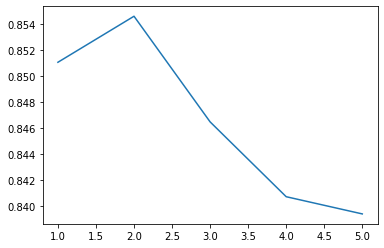

In [122]:
checkpoint_path = './cp.ckpt/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()

checkpoint_path = './cp.ckpt/'
list_auc_score = []
list_epoch = []

for chkpt in list_checkpoints[65:70]: #testing 65:70 to keep cycles quick for testing.
    filepath_chkpt = checkpoint_path + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])
    
#     model = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dropout(.5),
#                               keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])
    
#     model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)
    
    mod = Model()
    model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)

    model.load_weights(filepath_chkpt)

    predictions = model.predict(pp.test_sample, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    
    chkpt_num = chkpt[3:7]
    print('epoch / checkpoint:', chkpt_num, 'auc_score:', auc_score)    
#     cm = confusion_matrix(pp.test_label, rounded_predictions)
    
list_epoch = []
for val in range(1, len(list_auc_score) + 1):
    list_epoch.append(val)

plt.plot(list_epoch, list_auc_score)

In [120]:
# use this in method to run scoring on 

# append each val to list and then call order command to order the list 
# Method for fine tuning threshold

# we need to score each threshold for each epoch/checkpoint, then select the highest auc score, then select
# the corresponding threshold, then take that .x threshold and calculate the correct list of fine tuned
# thresholds to test, then test the fine tune threshold and select the highest auc score and corresponding
# threshold. During this entire time, we need to store the epoch #, and every threshold score in a 
# pandas dataframe, then return the highest auc roc score along with the best threshold to use and print that
# info out, then automatically store and save the best model in SavedModel / .tf method. 

list_tune_thres = []

best_thres = .1
temp_val_neg = .1
temp_val_pos = .1
for val in range(0,5):
    temp_val_neg = temp_val_neg - .01
    temp_val_pos = temp_val_pos + .01
    list_tune_thres.append(round(temp_val_neg, 2))
    list_tune_thres.append(round(temp_val_pos, 2))
list_tune_thres.append(round(best_thres, 2))    
    
list_tune_thres.sort()
list_tune_thres

[0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]

In [121]:
####################################
from sklearn.preprocessing import binarize
y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)

list_threshold = [.05, .1, .15, .2, .25, .3, 
                  .35, .4, .45, .5, .55, .6, 
                  .65, .7, .75, .8, .85, .9]

# list_threshold = [.31, .32, .33, .34, .35, .36, 
#                   .37, .38, .39, .4, .41, .42,.43,.44,.45,.46]

for threshold in list_threshold:
    y_pred_class = binarize(y_pred, threshold)#[:,1]
    fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred_class, pos_label=1)
    auc_score = auc(fpr, tpr)
    # list_auc_score.append(auc_score)
    print('auc_score:', auc_score, threshold)  

auc_score: 0.836341444785624 0.31
auc_score: 0.8360924923007299 0.32
auc_score: 0.8350981566825664 0.33
auc_score: 0.833215746999691 0.34
auc_score: 0.8321989588303216 0.35
auc_score: 0.8318507202157523 0.36
auc_score: 0.8319405304205765 0.37
auc_score: 0.8308469086727379 0.38
auc_score: 0.8297093820229171 0.39
auc_score: 0.828735998655315 0.4
auc_score: 0.8287819039581568 0.41
auc_score: 0.8262414208457617 0.42
auc_score: 0.8254212045348828 0.43
auc_score: 0.8236146282300466 0.44
auc_score: 0.8224546490290197 0.45
auc_score: 0.8215905278161584 0.46


In [83]:
#CURRENT!
# This is the code we are using to create our model class. 
# NEXT, should we load model weights and use this as our method? 
# should we just load the model? Well, we do want to show them all our details, so we should do this all.

# import tensorflow as tf
# import numpy as np 

# neg, pos = np.bincount(train_sample['0'])
# initial_bias = np.log([pos/neg])
# output_bias = tf.keras.initializers.Constant(initial_bias)

# loss = keras.losses.BinaryCrossentropy()

# checkpoint_path = "./cp.ckpt/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
#                                                  monitor='val_auc', 
#                                                  verbose=1,
#                                                  save_best_only=False, 
#                                                  save_weights_only=True,
#                                                  mode='max',
#                                                  save_freq='epoch')

# creating model
# lr = .0001
# metrics = [keras.metrics.AUC(name='auc'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.FalseNegatives(name='fn')]

# model = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# # model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
# #                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
# #                           keras.layers.Dropout(.5),
# #                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)

# saving weights for checkpoints
# model.save_weights(checkpoint_path.format(epoch=0))

# epochs = 2
# # fitting model
# model.fit(pp.train_sample, pp.train_label, validation_data=(pp.val_sample, pp.val_label), 
#           batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
#           use_multiprocessing=True,
#           callbacks=[cp_callback])

# NEXT, create a class that run through each model, threshold and tiny threshold 

checkpoint_path = './cp.ckpt/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()

In [85]:
# # CURRENT!
# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt/'
# list_auc_score = []
# list_epoch = []

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

# #     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
# #                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
# #                           keras.layers.Dropout(.5),
# #                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])
    
#     model = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dropout(.5),
#                               keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])
    
#     model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)

#     model.load_weights(filepath_chkpt)

#     predictions = model.predict(pp.test_sample, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
    
#     chkpt_num = chkpt[3:7]
#     print('epoch/checkpoint:', chkpt_num, 'auc_score:', auc_score)    
#     cm = confusion_matrix(pp.test_label, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)

# plt.plot(list_epoch, list_auc_score)

epoch/checkpoint: 0000 auc_score: 0.5012325521854574
epoch/checkpoint: 0001 auc_score: 0.8108817325341947
epoch/checkpoint: 0002 auc_score: 0.8183964721761776
epoch/checkpoint: 0003 auc_score: 0.8288777153655597
epoch/checkpoint: 0004 auc_score: 0.8332861572130622
epoch/checkpoint: 0005 auc_score: 0.8298790264074996
epoch/checkpoint: 0006 auc_score: 0.8274438566065901


KeyboardInterrupt: 

epoch: 1 auc_score: 0.49883807235657746
epoch: 2 auc_score: 0.7928097864286312
epoch: 3 auc_score: 0.8104485288415588


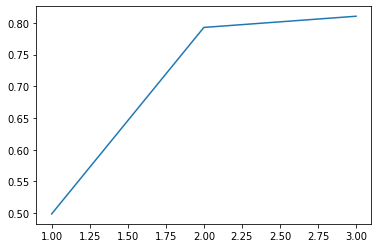

In [51]:
# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt/'
# list_auc_score = []
# list_epoch = []
# val_epoch = 0

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(pp.train_sample.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

#     model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)
    
#     model.load_weights(filepath_chkpt)
    
#     predictions = model.predict(pp.test_sample, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
#     val_epoch = val_epoch + 1
#     print('epoch:', val_epoch, 'auc_score:', auc_score)    
#     cm = confusion_matrix(pp.test_label, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)

# plt.plot(list_epoch, list_auc_score)

In [ ]:
# # Final model - for non OOP dataset
# list_auc_score = []
# path_savedmodel = '/Users/krahman/work/tutorials/tensorflow_classification/saved_models_2/'
# model = tf.keras.models.load_model(path_savedmodel)

# predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
# rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
# fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
# auc_score = auc(fpr, tpr)
# list_auc_score.append(auc_score)
# # val_epoch = val_epoch + 1
# print('auc_score:', auc_score)    
# cm = confusion_matrix(test_labels, rounded_predictions)

In [ ]:
# # TESTING
# # creating Modelcheckpoint
# checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
#                                                  monitor='val_auc', 
#                                                  verbose=1,
#                                                  save_best_only=False, 
#                                                  save_weights_only=True,
#                                                  mode='max',
#                                                  save_freq='epoch')


# # creating model
# epochs = 10
# lr = .0001
# metrics = [keras.metrics.AUC(name='auc'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.FalseNegatives(name='fn')]

# model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# # Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
# #       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
# #       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
# model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# # saving weights for checkpoints
# model.save_weights(checkpoint_path.format(epoch=0))


# # fitting model
# model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
#           batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
#           use_multiprocessing=True,
#           callbacks=[cp_callback])


# # now that all epochs have completed, we will test load and test each weight. 
# # parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# # a list of all model weights to parse through for testing results against the test set. 
# checkpoint_path = './cp.ckpt.testing2/'
# list_checkpoints = []
# for file in os.listdir(checkpoint_path):
#     val_checkpoint = file[0:12]
#     if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
#         list_checkpoints.append(val_checkpoint)
# list_checkpoints.sort()


# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt.testing2/'
# list_auc_score = []
# list_epoch = []
# val_epoch = 0

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                               keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                               keras.layers.Dropout(.5),
#                               keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    
#     model.load_weights(filepath_chkpt)
#     predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
#     val_epoch = val_epoch + 1
#     print('epoch:', val_epoch, 'auc_score:', auc_score)    
#     cm = confusion_matrix(test_labels, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)
    
# plt.plot(list_epoch, list_auc_score)

In [ ]:
# # TESTING
# # creating Modelcheckpoint
# checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
#                                                  monitor='val_auc', 
#                                                  verbose=1,
#                                                  save_best_only=False, 
#                                                  save_weights_only=True,
#                                                  mode='max',
#                                                  save_freq='epoch')


# # creating model
# epochs = 10
# lr = .0001
# metrics = [keras.metrics.AUC(name='auc'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.FalseNegatives(name='fn')]

# model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
# #                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# # Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
# #       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
# #       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
# model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# # saving weights for checkpoints
# model.save_weights(checkpoint_path.format(epoch=0))


# # fitting model
# model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
#           batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
#           use_multiprocessing=True,
#           callbacks=[cp_callback])


# # now that all epochs have completed, we will test load and test each weight. 
# # parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# # a list of all model weights to parse through for testing results against the test set. 
# checkpoint_path = './cp.ckpt.testing2/'
# list_checkpoints = []
# for file in os.listdir(checkpoint_path):
#     val_checkpoint = file[0:12]
#     if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
#         list_checkpoints.append(val_checkpoint)
# list_checkpoints.sort()


# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt.testing2/'
# list_auc_score = []
# list_epoch = []
# val_epoch = 0

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                               keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)),
#                               keras.layers.Dropout(.5),
#                               keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
#     model.load_weights(filepath_chkpt)
#     predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
#     val_epoch = val_epoch + 1
#     print('epoch:', val_epoch, 'auc_score:', auc_score)    
#     cm = confusion_matrix(test_labels, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)
    
# plt.plot(list_epoch, list_auc_score)

In [ ]:
# # TESTING
# # creating Modelcheckpoint
# checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
#                                                  monitor='val_auc', 
#                                                  verbose=1,
#                                                  save_best_only=False, 
#                                                  save_weights_only=True,
#                                                  mode='max',
#                                                  save_freq='epoch')


# # creating model
# epochs = 55
# lr = .0001
# metrics = [keras.metrics.AUC(name='auc'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.FalseNegatives(name='fn')]

# model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# # Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
# #       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
# #       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
# model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# # saving weights for checkpoints
# model.save_weights(checkpoint_path.format(epoch=0))


# # fitting model
# model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
#           batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
#           use_multiprocessing=True,
#           callbacks=[cp_callback])


# # now that all epochs have completed, we will test load and test each weight. 
# # parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# # a list of all model weights to parse through for testing results against the test set. 
# checkpoint_path = './cp.ckpt.testing2/'
# list_checkpoints = []
# for file in os.listdir(checkpoint_path):
#     val_checkpoint = file[0:12]
#     if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
#         list_checkpoints.append(val_checkpoint)
# list_checkpoints.sort()


# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt.testing2/'
# list_auc_score = []
# list_epoch = []
# val_epoch = 0

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
#     model.load_weights(filepath_chkpt)
#     predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
#     val_epoch = val_epoch + 1
#     print('epoch:', val_epoch, 'auc_score:', auc_score)    
#     cm = confusion_matrix(test_labels, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)
    
# plt.plot(list_epoch, list_auc_score)

In [ ]:
# # TESTING
# # creating Modelcheckpoint
# checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
#                                                  monitor='val_auc', 
#                                                  verbose=1,
#                                                  save_best_only=False, 
#                                                  save_weights_only=True,
#                                                  mode='max',
#                                                  save_freq='epoch')


# # creating model
# epochs = 10
# lr = .0001
# metrics = [keras.metrics.AUC(name='auc'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.FalseNegatives(name='fn')]

# model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# # Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
# #       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
# #       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
# model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# # saving weights for checkpoints
# model.save_weights(checkpoint_path.format(epoch=0))


# # fitting model
# model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
#           batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
#           use_multiprocessing=True,
#           callbacks=[cp_callback])


# # now that all epochs have completed, we will test load and test each weight. 
# # parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# # a list of all model weights to parse through for testing results against the test set. 
# checkpoint_path = './cp.ckpt.testing2/'
# list_checkpoints = []
# for file in os.listdir(checkpoint_path):
#     val_checkpoint = file[0:12]
#     if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
#         list_checkpoints.append(val_checkpoint)
# list_checkpoints.sort()


# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt.testing2/'
# list_auc_score = []
# list_epoch = []
# val_epoch = 0

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
#     model.load_weights(filepath_chkpt)
#     predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
#     val_epoch = val_epoch + 1
#     print('epoch:', val_epoch, 'auc_score:', auc_score)    
#     cm = confusion_matrix(test_labels, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)
    
# plt.plot(list_epoch, list_auc_score)

In [ ]:
# # TESTING
# # creating Modelcheckpoint
# checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
#                                                  monitor='val_auc', 
#                                                  verbose=1,
#                                                  save_best_only=False, 
#                                                  save_weights_only=True,
#                                                  mode='max',
#                                                  save_freq='epoch')


# # creating model
# epochs = 10
# lr = .0001
# metrics = [keras.metrics.AUC(name='auc'),
#            keras.metrics.FalsePositives(name='fp'),
#            keras.metrics.FalseNegatives(name='fn')]

# model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# # Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
# #       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
# #       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
# model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# # saving weights for checkpoints
# model.save_weights(checkpoint_path.format(epoch=0))


# # fitting model
# model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
#           batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
#           use_multiprocessing=True,
#           callbacks=[cp_callback])


# # now that all epochs have completed, we will test load and test each weight. 
# # parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# # a list of all model weights to parse through for testing results against the test set. 
# checkpoint_path = './cp.ckpt.testing2/'
# list_checkpoints = []
# for file in os.listdir(checkpoint_path):
#     val_checkpoint = file[0:12]
#     if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
#         list_checkpoints.append(val_checkpoint)
# list_checkpoints.sort()


# # parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
# filepath_checkpoint_folder = './cp.ckpt.testing2/'
# list_auc_score = []
# list_epoch = []
# val_epoch = 0

# for chkpt in list_checkpoints:
#     filepath_chkpt = filepath_checkpoint_folder + chkpt

#     model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
#                                              bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
# #                                              kernel_constraint=l2(0.0001),
# #                                              bias_constraint=l2(0.0001)
#                                             ),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
#     model.load_weights(filepath_chkpt)
#     predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
#     rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
#     fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
#     auc_score = auc(fpr, tpr)
#     list_auc_score.append(auc_score)
#     val_epoch = val_epoch + 1
#     print('epoch:', val_epoch, 'auc_score:', auc_score)    
#     cm = confusion_matrix(test_labels, rounded_predictions)
    
# list_epoch = []
# for val in range(1,len(list_auc_score) + 1):
#     list_epoch.append(val)
    
# plt.plot(list_epoch, list_auc_score)